In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rc('font', **{'family': 'Microsoft YaHei, SimHei'})  # 设置中文字体的支持
plt.rcParams['axes.unicode_minus'] = False
# 解决保存图像是负号'-'显示为方块的问题

## 数据探索

In [2]:
df = pd.read_csv('城市经济.csv')
df

,area,GDP,人均GDP,工业增加值,第三产业增加值,固定资产投资,基本建设投资,社会消费品零售总额,海关出口总额,地方财政收入
0,山东,10550.0,11643,3502.5,3851.0,2288.7,1070.7,3181.9,211.1,610.2
1,河北,6076.6,9047,1406.7,2092.6,1161.6,597.1,1968.3,45.9,302.3
2,天津,2022.6,22068,822.8,960.0,703.7,361.9,941.4,115.7,171.8
3,江苏,10636.3,14397,3536.3,3967.2,2320.0,1141.3,3215.8,384.7,643.7
4,上海,5408.8,40627,2196.2,2755.8,1970.2,779.3,2035.2,320.5,709.0
5,浙江,7670.0,16570,2356.5,3065.0,2296.6,1180.6,2877.5,294.2,566.9
6,福建,4682.0,13510,1047.1,1859.0,964.5,397.9,1663.3,173.7,272.9
7,广东,11769.7,15030,4224.6,4793.6,3022.9,1275.5,5013.6,1843.7,1201.6
8,广西,2455.4,5062,367.0,995.7,542.2,352.7,1025.5,15.1,186.7


In [3]:
import seaborn as sns
sns.set(font='SimHei')  # 解决Seaborn中文显示问题，

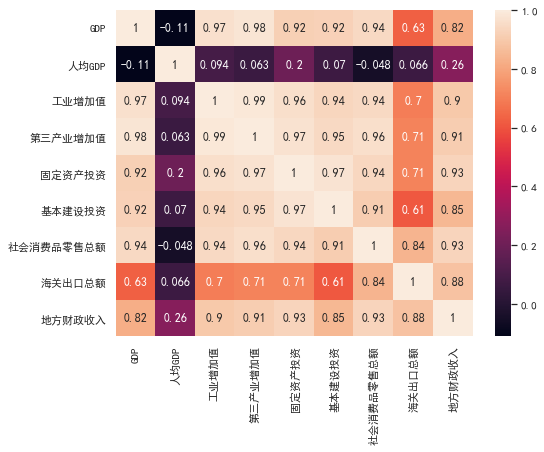

In [4]:
plt.figure(figsize=(8, 6))
sns.heatmap(data=df.corr(), annot=True) # annot=True: 显示数字
# 变量间呈现较高的相关性，需要进行变量压缩

## PCA 建模

### 数据标准化
使用中心标准化，即将变量都转化成 z 分数的形式，避免量纲问题对压缩造成影响

In [5]:
from sklearn.preprocessing import scale
data = df.drop(columns='area') # 丢弃无用的类别变量
data = scale(data)

### 初步建模

In [6]:
from sklearn.decomposition import PCA

# 说明：
## 1. 第一次的 n_components 参数最好设置得大一些（保留的主成份）
## 2. 观察 explained_variance_ratio_ 取值变化，即每个主成分能够解释原始数据变异的百分比
pca = PCA(n_components=len(data)) # 直接与变量个数相同的主成分
pca.fit(data)

PCA(n_components=9)

## 结果分析

### 累积解释变异程度

In [7]:
# 累积解释变异程度
pca.explained_variance_ratio_

array([8.01228521e-01, 1.22511074e-01, 6.21541492e-02, 9.94725332e-03,
       2.46475660e-03, 1.34733699e-03, 2.11552456e-04, 1.35356084e-04,
       1.72250209e-35])

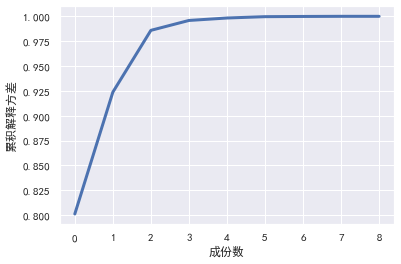

In [8]:
plt.plot(np.cumsum(pca.explained_variance_ratio_), linewidth=3)
plt.xlabel('成份数')
plt.ylabel('累积解释方差'); plt.grid(True)

### 重新建模

In [9]:
# 可知两个主成分就已经足够了
pca = PCA(n_components=2) # 直接与变量个数相同的主成分
pca.fit(data)

pca.explained_variance_ratio_

array([0.80122852, 0.12251107])

In [10]:
new_data = pca.fit_transform(data) #  fit_transform 表示将生成降维后的数据
# 查看规模差别
print("原始数据集规模:   ", data.shape)
print("降维后的数据集规模:", new_data.shape)
# 9 个变量压缩成两个主成分

原始数据集规模:    (9, 9)
降维后的数据集规模: (9, 2)


### 主成分中各变量的权重分析

In [11]:
# 两个主成分与 9 个变量的系数关系
results = pd.DataFrame(pca.components_).T
results.columns = ['pca_1', 'pca_2']
results.index = df.drop(columns='area').columns
results

,pca_1,pca_2
GDP,0.353645,-0.211802
人均GDP,0.034093,0.942455
工业增加值,0.364282,-0.013027
第三产业增加值,0.367803,-0.040553
固定资产投资,0.365715,0.098109
基本建设投资,0.352785,-0.032065
社会消费品零售总额,0.366340,-0.123313
海关出口总额,0.295610,0.051071
地方财政收入,0.354963,0.191407


    1. 主成分1几乎不受 data 的第二个自变量 ‘人均GDP’ 的影响，0.034，其他自变量对其影响程度都差不多
    
    2. 主成分2受 data 的第二个自变量 ‘人均GDP’ 影响最大，达到了 0.94

## 结果描述
目前我们把 9 个自变量压缩成了 2 个主成分，每个主成分受哪些变量的影响也有了了解

虽然得到的主成分都没有什么意义，但我们是否可以通过变量们对主成分的影响程度

来为生成的两个主成分命名呢？


答案：
    
    第一个主成分在表达经济总量的指标上的权重相当，可命名为 “经济总量水平”
    而第二个主成分只在人均GDP上权重很高，可命名为 “人均水平”
    
###### 重点！
给两个主成分“命名”是对降维后的数据进行，

而不是 pca.components_ 打印出来的个变量在成份上的权重

In [12]:
# 重建索引，让主成分的数据框的索引与最初的数据表的索引一样
results = results.reset_index().drop(columns='index')
results

,pca_1,pca_2
0,0.353645,-0.211802
1,0.034093,0.942455
2,0.364282,-0.013027
3,0.367803,-0.040553
4,0.365715,0.098109
5,0.352785,-0.032065
6,0.366340,-0.123313
7,0.295610,0.051071
8,0.354963,0.191407


In [13]:
new_data = pca.fit_transform(data) #  fit_transform 表示将生成降维后的数据
results = df.join(pd.DataFrame(new_data, 
                        columns=['经济总量水平', '人均水平'])) # 与原来的数据拼接
results

,area,GDP,人均GDP,工业增加值,第三产业增加值,固定资产投资,基本建设投资,社会消费品零售总额,海关出口总额,地方财政收入,经济总量水平,人均水平
0,山东,10550.0,11643,3502.5,3851.0,2288.7,1070.7,3181.9,211.1,610.2,1.860242,-0.742343
1,河北,6076.6,9047,1406.7,2092.6,1161.6,597.1,1968.3,45.9,302.3,-1.501490,-0.812491
2,天津,2022.6,22068,822.8,960.0,703.7,361.9,941.4,115.7,171.8,-3.230442,0.752090
3,江苏,10636.3,14397,3536.3,3967.2,2320.0,1141.3,3215.8,384.7,643.7,2.150940,-0.451596
4,上海,5408.8,40627,2196.2,2755.8,1970.2,779.3,2035.2,320.5,709.0,0.134468,2.634167
5,浙江,7670.0,16570,2356.5,3065.0,2296.6,1180.6,2877.5,294.2,566.9,1.039212,-0.040699
6,福建,4682.0,13510,1047.1,1859.0,964.5,397.9,1663.3,173.7,272.9,-2.140110,-0.258758
7,广东,11769.7,15030,4224.6,4793.6,3022.9,1275.5,5013.6,1843.7,1201.6,5.145964,-0.120924
8,广西,2455.4,5062,367.0,995.7,542.2,352.7,1025.5,15.1,186.7,-3.458783,-0.959445


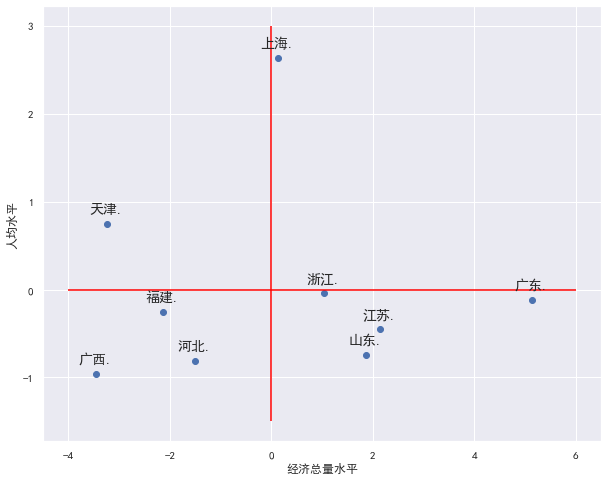

In [14]:
plt.figure(figsize=(10, 8))
# 基础散点图
x, y = results['经济总量水平'], results['人均水平']
label = results['area']
plt.scatter(x, y)
plt.xlabel('经济总量水平'); plt.ylabel('人均水平')

# 对散点图中的每一个点进行文字标注
 ## 固定代码，无需深究，拿来即用
for a,b,l in zip(x,y,label):
    plt.text(a, b+0.1, '%s.' % l, ha='center', va= 'bottom',fontsize=14)

# 添加两条竖线
plt.vlines(x=results['经济总量水平'].mean(), 
           ymin=-1.5, ymax=3, colors='red')
plt.hlines(y=results['人均水平'].mean(), 
           xmin=-4, xmax=6, colors='red')

- 广西，河北，福建三地的人均水平和经济总量水平都偏低
- 上海的人均经济水平很高，但经济总量水平缺只是略优于均值一点点
- 广东的人均经济水平稍次于均值，但经济总量水平很高
- ....